# Image Similarity using Color Histogram

## 💡 1. Introduction

### 1.1 The objective
In the [SIFT](https://github.com/i442124/SuperScope/blob/main/notebooks/feature-extraction/Feature_Extraction_SIFT.ipynb)  feature extraction notebook, we've noticed a considerable slowdown in computation times when dealing with larger collections. We want to find out if we can use the color information stored in these images to strategically decide what images we want to perform feature descriptor matching on in the hopes of gaining a boost in performance when scanning the box art of a video game.

### 1.2 About this document
This document serves as a consistent environment to see and experiment how the different parameters can have an influence on finding the optimal set of images that we pass through to the SIFT feature descriptor matcher. In this document, I will write down all the thoughts, ideas, hypotheses and discoveries I've made along the way.

## ⚙️ 2. Settings

In [1]:
## SETTINGS FOR QUERY_IMAGES
QUERY_IMAGES_PATH = '../../data/box-art/samples/query-images'

## SETTINGS FOR TARGET_IMAGES
TARGET_IMAGES_PATH = '../../data/box-art/samples/target-images'

## COLOR VALUES ARE STORED IN BYTE VALUES BETWEEN 0 - 255
## BINS GROUP THE ENTIRE RANGE OF VALUES INTO
## THE TOTAL NUMBER OF BINS AVAILABLE
N_BINS = 8

## 📚 3. Preperations

### 3.1 Importing libraries
For extracting the color histogram from an image I'm going to use the OpenCV library. OpenCV is an open-source computer vision and machine learning software library that provides a common infrastructure for computer vision applications. More info about OpenCV can be found at https://opencv.org/about/

I've also included a [helper](https://github.com/i442124/SuperScope/blob/main/notebooks/feature-extraction/helper.py) module with some common functionality that we will see across all notebooks regarding image (pre)processing. This allows us to focus solely on the topic of the color histograms in this document. I'd recommend that you'd read this module at your own leisure after finishing this notebook.

In [2]:
import cv2
import helper
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

### 3.2 Importing datasets
The datasets consist of two separate types of images called query images and target images. The query images are images captured with my mobile phone of the a video game. The target images are high quality rips of the box art images that can be found on the query images. The location of these images are provided by the `QUERY_IMAGES_PATH` and the `TARGET_IMAGES_PATH` variables.

In [3]:
QUERY_IMAGES = helper.load_images_in_dir(QUERY_IMAGES_PATH)
QUERY_IMAGES.head(5)

label                                              image
0  animal.jpg  [[[191, 188, 179], [190, 187, 178], [190, 185,...
1  donkey.jpg  [[[189, 184, 162], [189, 184, 162], [190, 185,...
2  hyrule.jpg  [[[175, 179, 164], [174, 178, 163], [172, 174,...
3   mario.jpg  [[[166, 163, 148], [167, 164, 149], [170, 167,...
4   smash.jpg  [[[147, 144, 125], [147, 144, 125], [150, 144,...

In [4]:
TARGET_IMAGES = helper.load_images_in_dir(TARGET_IMAGES_PATH)
TARGET_IMAGES.head(5)

label                                              image
0  animal.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1  donkey.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
2  hyrule.jpg  [[[207, 204, 197], [208, 205, 198], [210, 207,...
3   mario.jpg  [[[251, 251, 251], [254, 254, 254], [255, 255,...
4   smash.jpg  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

## 🎨 4. Spectating the images

### 4.1 Query Images
Let’s start off with looking at the query images I took. These images are supposed to represent a picture someone would take what they intend to scan a video game of interest. I purposefully added a little background noise and some glares from the light source onto the box-art to distort the image enough so we can be sure that the approach is flexible enough to be used the environment we are aiming for.

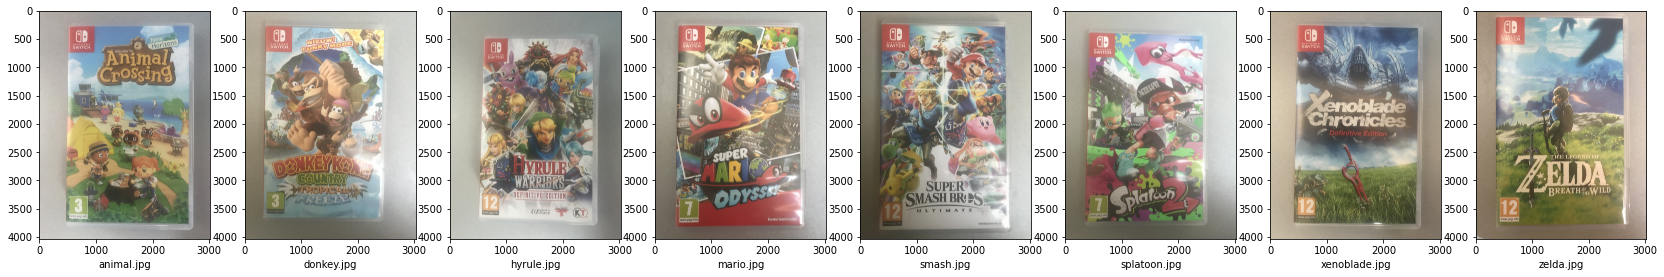

In [5]:
helper.spectate_image_set(QUERY_IMAGES)

### 4.2 Target Images
Next, we have the target images. These are the original box art images as they are provided with the game. They are supposed to be vibrant and clear with no noise nor distortions in lightning. They are the ideal 'target' of how a picture should look when captured with the camera. In optimal conditions, the query images should match these images exactly in terms of color and brightness.

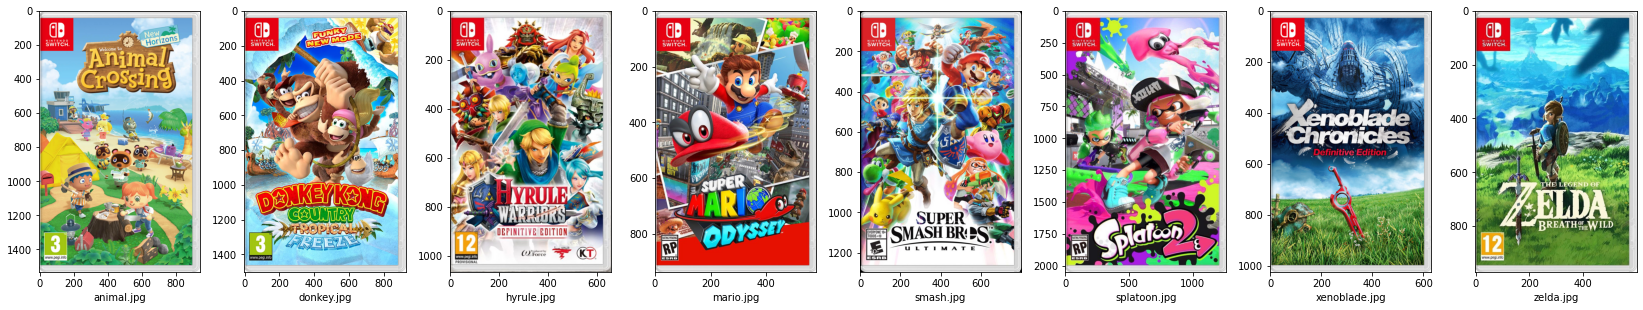

In [6]:
helper.spectate_image_set(TARGET_IMAGES)

## 🧪 5. Experimentation

### 5.1 Understanding the color histogram
Before we start with comparing the color histograms of the images, it's best to gain a better understanding of what exactly we want to look at. A [color histogram](https://pyimagesearch.com/wp-content/uploads/2014/01/flattened_color.png) tells us a lot about the distribution of colors in an image. Let's read the color histogram of the first image in our dataset and see if we can spot some details about our image in the histogram.

In [7]:
def extract_channel_histogram(image, channel, normalize=False, n_bins=256):
    hist = cv2.calcHist([image], [channel], None, [n_bins], [0, 256])
    hist = cv2.normalize(hist, None) if normalize else hist
    return hist

In [8]:
def plot_color_histogram(image, normalize=False, n_bins=256):
    
    # plot params
    plt.xlim(0, n_bins-1)
    plt.xlabel('Intensity')
    plt.ylabel('Number of pixels')
    
    # loop over the image channels
    for idx, color in enumerate(['r', 'g', 'b']):
        
        # create a histogram for the current channel
        # and concatenate the result into the plot
        hist = extract_channel_histogram(image, idx, normalize, n_bins)
        plt.plot(hist, color=color)

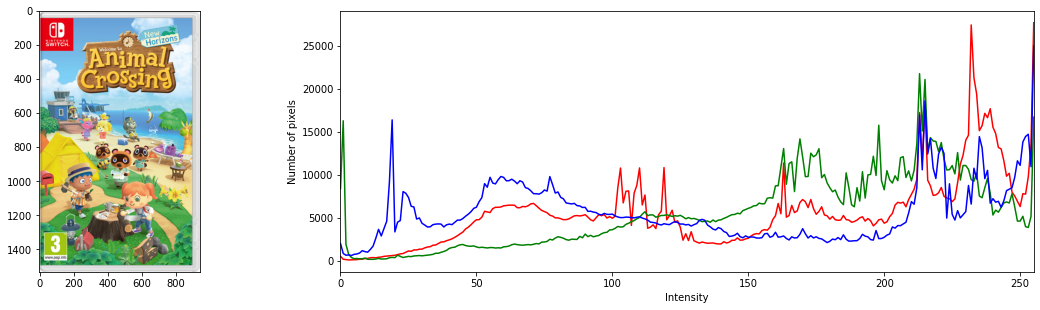

In [9]:
## INITIALIZE THE FIGURE
plt.figure(figsize=(19.2, 4.8))

## SHOW THE TARGET IMAGE
plt.subplot2grid((1, 3), (0, 0))
plt.imshow(TARGET_IMAGES.iloc[0]['image'])

## SHOW THE HISTOGRAM OF THE TARGET IMAGE
plt.subplot2grid((1, 3), (0, 1), colspan=2)
plot_color_histogram(TARGET_IMAGES.iloc[0]['image'])

Let's break down the axis of the graph first. On the X-axis we have the intensity of the pixel. A high intensity means that this pixel is very 'bright' in color. As the number of bins decrease (currently we have 256 bins, one bin for each possible pixel value) the more pixels intensities are being grouped together. You could for instance only have 4 bins, (very dark red, dark red, red and bright red). The Y-axis then tells us how many pixels are within the bin. You could normalize these values to make them resolution independent!

With this knowledge we should be able to spot some patterns. For example, in the graph above we can see that we have a lot of greens (160 through 225), which is most likely the patches of grass in the image. We also see a small spike in the red color around the 235 mark, which is most likely the Nintendo switch logo on the top left (very bright red). These are the exact patterns we want to look for in the query images so we will be able to reduce our large collection of images into only a small set of images with similar color attributes.

### 5.2 Inspecting the color histograms
Now that we have some idea on how to read the color histograms, let's put all the images we have in a side by side list to see how these images stack up against each other and give us an initial impression on how good this approach could be for finding good matches between the histograms. I'm going to use the `N_BINS` hyper-parameter to reduce the amount of bins to the desired count. Make sure to spectate these images to see the changes!

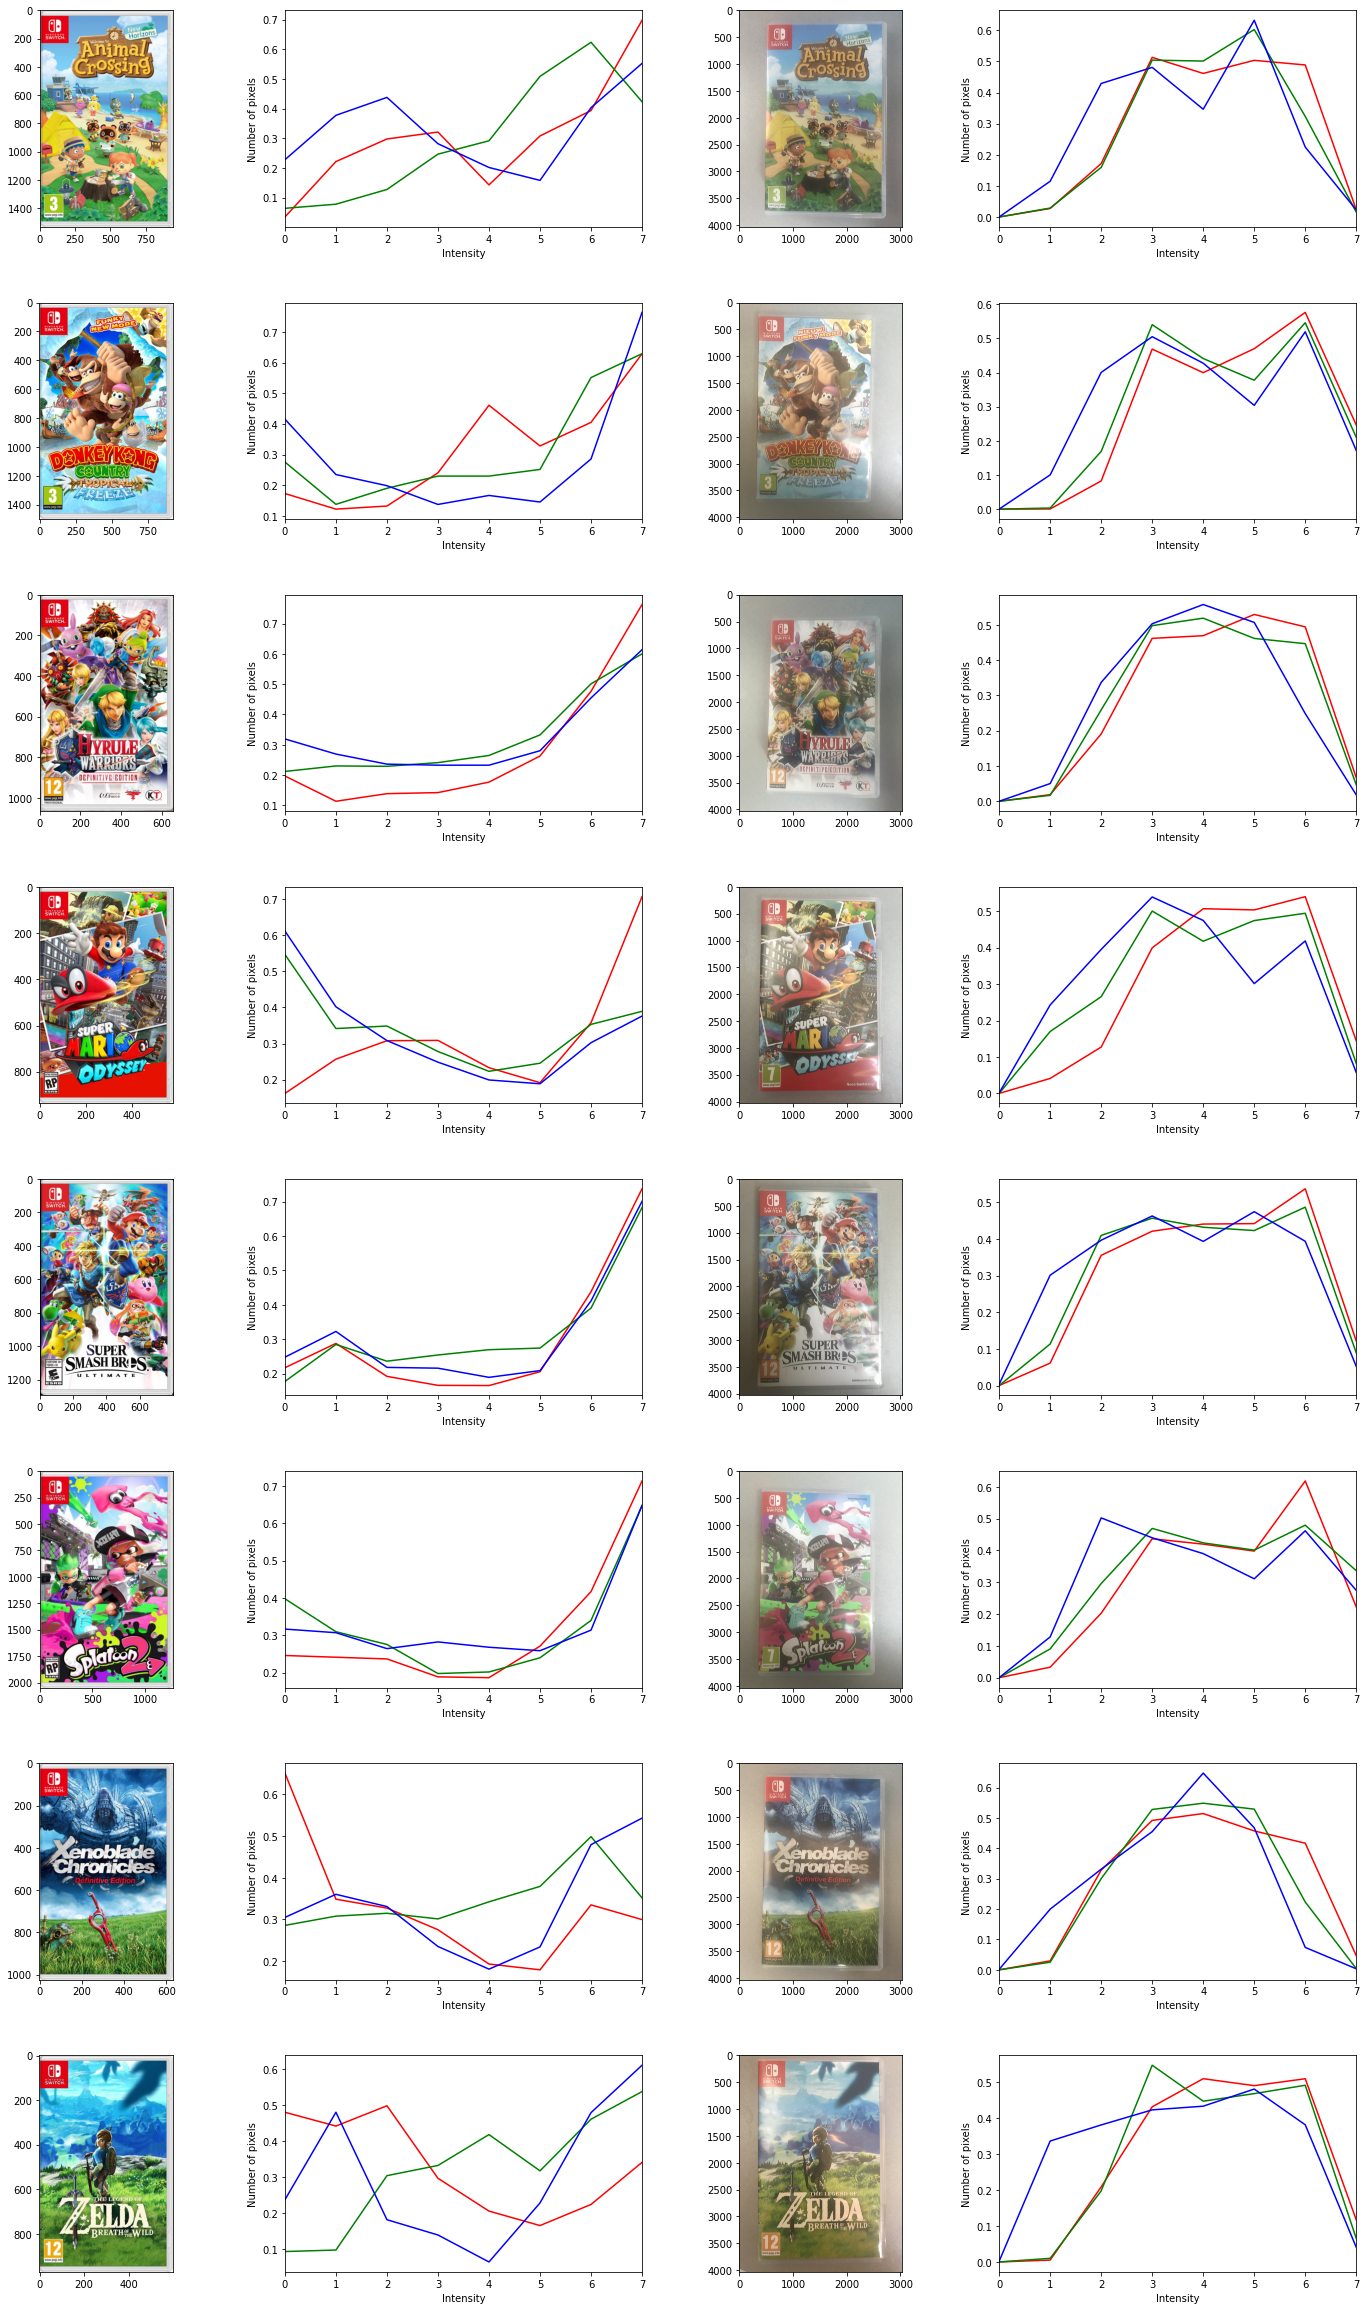

In [10]:
ncols = 2 * 2
nrows = len(TARGET_IMAGES)

## INITIALIZE THE FIGURE
plt.figure(figsize=(6.4*ncols, 5.2*nrows))
plt.subplots_adjust(wspace=0, hspace=0.35)

## LOOP THROUGH ALL IMAGES
values = zip(QUERY_IMAGES.iterrows(), TARGET_IMAGES.iterrows())
for idx, ((_, query), (_, target)) in enumerate(values):
    
    ## SHOW TARGET IMAGE
    plt.subplot(nrows, ncols, ncols * idx + 1)
    plt.imshow(target['image'])
    
    ## SHOW TARGET HISTOGRAM
    plt.subplot(nrows, ncols, ncols * idx + 2)
    plot_color_histogram(target['image'], normalize=True, n_bins=N_BINS)
    
    ## SHOW QUERY IMAGE
    plt.subplot(nrows, ncols, ncols * idx + 3)
    plt.imshow(query['image'])

    ## SHOW QUERY HISTOGRAM
    plt.subplot(nrows, ncols, ncols * idx + 4)
    plot_color_histogram(query['image'], normalize=True, n_bins=N_BINS)   

When we take a look at the target images (on the left) we can see that most of these images have very distinct shapes. They also fully utilize the entire color space they have available, which makes sense since their digitally scanned images.

Sadly, we can't say the same for the query images (on the right). Most of the images have the same overall shape which makes them very difficult to differentiate them from each other. This makes me worried that the dim lightning in these images caused a huge amount of information loss that we need to find a good correlation between the query and target images...

### 5.3 Combining the histograms
Now that we've made an initial hypothesis, we can move on to prepare the histograms to be compared against each other. Currently we've been extracting the color channels into separate variables. This is very useful when we want to visualize them individually, but it's not as efficient when we want to compare the entirety of histograms with each other. Let's recalculate the color histograms into a single numpy array.

In [11]:
def extract_color_histogram(image, normalize=True):
    hist = cv2.calcHist([image], [0, 1, 2], None, [N_BINS, N_BINS, N_BINS], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None) if normalize else hist
    return hist

In [12]:
QUERY_IMAGES['histogram'] = QUERY_IMAGES['image'].apply(extract_color_histogram)
QUERY_IMAGES[['label', 'histogram']].head(5)

label                                          histogram
0  animal.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...
1  donkey.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...
2  hyrule.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...
3   mario.jpg  [[[3.681824e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4   smash.jpg  [[[4.0873906e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

In [13]:
TARGET_IMAGES['histogram'] = TARGET_IMAGES['image'].apply(extract_color_histogram)
TARGET_IMAGES[['label', 'histogram']].head(5)

label                                          histogram
0  animal.jpg  [[[0.005966294, 0.000978845, 0.0003122982, 9.3...
1  donkey.jpg  [[[0.042184766, 0.0016668213, 0.00014629017, 0...
2  hyrule.jpg  [[[0.070353694, 0.025543137, 0.004409121, 0.0,...
3   mario.jpg  [[[0.09146236, 0.017554725, 0.0034945959, 0.00...
4   smash.jpg  [[[0.15967986, 0.01081522, 0.002414968, 0.0005...

With the histograms calculated, we can start generating paired combinations between each row of the query images with each row of the target images. Because the column names are the same for the query and target images, we need to add a prefix (or suffix) to avoid collisions between them.

In [14]:
# add prefix to query columns
# and create a common cross join key
c_queries = QUERY_IMAGES[['label', 'histogram']]
c_queries = c_queries.add_prefix('query_')
c_queries['key'] = 0

# add prefix to target columns
# and create a common cross join key
c_targets = TARGET_IMAGES[['label', 'histogram']]
c_targets = c_targets.add_prefix('target_')
c_targets['key'] = 0

# cross join the query and target images 
# in the end, we should have N_QUERIES * N_TARGETS entries
cross = pd.merge(c_queries, c_targets, on='key')
cross = cross.drop(columns='key')
cross

query_label                                    query_histogram  \
0   animal.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
1   animal.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
2   animal.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
3   animal.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
4   animal.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
..         ...                                                ...   
59   zelda.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
60   zelda.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
61   zelda.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
62   zelda.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   
63   zelda.jpg  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...   

     target_label                                   target_histogram  
0      animal.jpg  [[[0.005966294, 0.000978845, 0.0003122982, 9.3...  
1      donkey.jpg  [[[0.042184766, 0.0016668213, 0.00014629017, 0...  
2      hyrule.jpg  [[[0.070353694, 0.025543137, 0.004409121, 0.0,...  
3       mario.jpg  [[[0.09146236, 0.017554725, 0.0034945959, 0.00...  
4       smash.jpg  [[[0.15967986, 0.01081522, 0.002414968, 0.0005...  
..            ...                                                ...  
59      mario.jpg  [[[0.09146236, 0.017554725, 0.0034945959, 0.00...  
60      smash.jpg  [[[0.15967986, 0.01081522, 0.002414968, 0.0005...  
61   splatoon.jpg  [[[0.40917367, 0.039917357, 0.00023409443, 4.6...  
62  xenoblade.jpg  [[[0.19370022, 0.20727232, 0.012696772, 0.0, 0...  
63      zelda.jpg  [[[0.0757559, 0.004661735, 0.00038937927, 0.0,...  

[64 rows x 4 columns]

### 5.4 Comparing the histograms
There are several techniques provided by OpenCV to compare the color histograms with each other. All of them use a slightly different approach so let's check which one of them would perform the best!

* `cv2.HISTCMP_CORREL`: Computes the correlation between the two histograms
* `cv2.HISTCMP_CHISQR`: Applies the Chi-Squared distance to the histograms.
* `cv2.HISTCMP_INTERSECT`: Calculates the intersection between the two histograms.
* `cv2.HISTCMP_BHATTACHARYYA` Bhattacharyya distance, used to measure the “overlap” between the two histograms.

We can use the `cv2.compareHist` function to compare the color histograms with each other.

In [15]:
def compareHist(row, method):
    H1 = row['query_histogram']
    H2 = row['target_histogram']
    return cv2.compareHist(H1, H2, method)

With this, we can start comparing our color histograms with each other.

In [16]:
OPENCV_METHODS = (
    ("Correlation", cv2.HISTCMP_CORREL),
    ("Chi-Squared", cv2.HISTCMP_CHISQR),
    ("Intersection", cv2.HISTCMP_INTERSECT),
    ("Hellinger", cv2.HISTCMP_BHATTACHARYYA))

# initialize the results
results = {}

# loop over the comparison methods
for (methodName, method) in OPENCV_METHODS:
    
    # compare the distance between the two histograms
    # using the comparison method and store the values
    cross[methodName] = cross.apply(compareHist, args=[method], axis=1)
    
    # create a nice looking matrix by pivoting the dataframe
    results[methodName] = cross.pivot(index='query_label', columns='target_label', values=methodName)

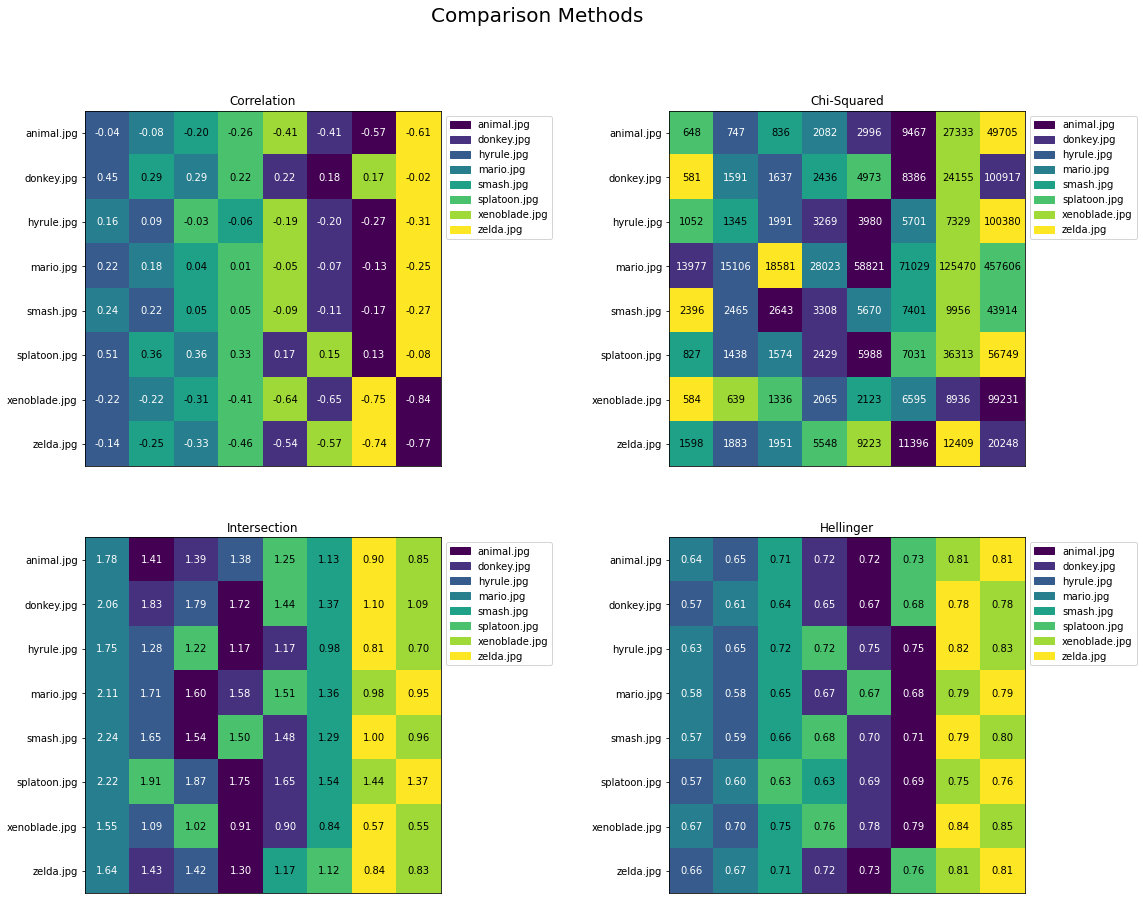

In [17]:
plt.figure(figsize=(19.2, 14.4))
plt.suptitle('Comparison Methods', fontsize=20)

plt.subplot(2, 2, 1)
plt.title('Correlation')
helper.plot_correlation_matrix(results['Correlation'], ascending=False, annot=True, annot_label='{:.2f}')

plt.subplot(2, 2, 2)
plt.title('Chi-Squared')
helper.plot_correlation_matrix(results['Chi-Squared'], ascending=True, annot=True, annot_label='{:.0f}')

plt.subplot(2, 2, 3)
plt.title('Intersection')
helper.plot_correlation_matrix(results['Intersection'], ascending=False, annot=True, annot_label='{:.2f}')

plt.subplot(2, 2, 4)
plt.title('Hellinger')
helper.plot_correlation_matrix(results['Hellinger'], ascending=True, annot=True, annot_label='{:.2f}')

When we look at the correlation of all the histograms, we can see a clear preferences to target images containing a lot of white/red pixels (mario.jpg and hyrule.jpg), which would make sense considering the warm light emitted from my desk lamp while taking these pictures. However the negative correlation between the correct query to target image (zelda.jpg as an example) is something I did not expect. Looks like the correlation between query and target images is not the solution we are looking for.

Chi-Squared is a bit more sporadic in it's approach. However most matches don't make much sense to me. I don't see any good relations between the box-art in the query image and the order of results of the target images making them feel kind of random. Sadly, this means Chi-Squared is not as useful to our use case as well.

Intersection has similar results to the correlation between images but worse. Images seem to be almost in a set order of appearance regardless of the box-art that is shown in the query image. Not usable for our use case.

Hellinger is no good either. Although the distance between targets is much smaller compared to the other methods used, blue images (like xenoblade.jpg and zelda.jpg) are still poorly judged while white/red are always among the best matches. Can't use this method either....

## 🕵️ 6. Investigation
Although I'd like to conclude the research as is, it annoys me that there are even negative correlations on images with the exact same box art on them. The preference to red/white images is a clear performance killer for the algorithm so let's investigate the color channels for one of the images with a high negative correlation that, in reality, should be an almost perfect match to see what exactly is going on.

In [18]:
def plot_color_channel(title, query, target):
    
    plt.figure(figsize=(19.2, 4.8))
    plt.suptitle(title)
    
    plt.subplot2grid((1, 4), (0, 0))
    plt.imshow(query, cmap='gray')
    plt.axis('off')
    
    plt.subplot2grid((1, 4), (0, 1))
    plt.imshow(target, cmap='gray')
    plt.axis('off')
    
    plt.subplot2grid((1, 4), (0, 2), colspan=2)        
    plt.plot(extract_channel_histogram(query, 0, normalize=True, n_bins=N_BINS), label='Query')
    plt.plot(extract_channel_histogram(target, 0, normalize=True, n_bins=N_BINS), label='Target')
    
    plt.ylabel('Number of pixels')
    plt.xlabel('Intensity')
    plt.legend(loc='best')

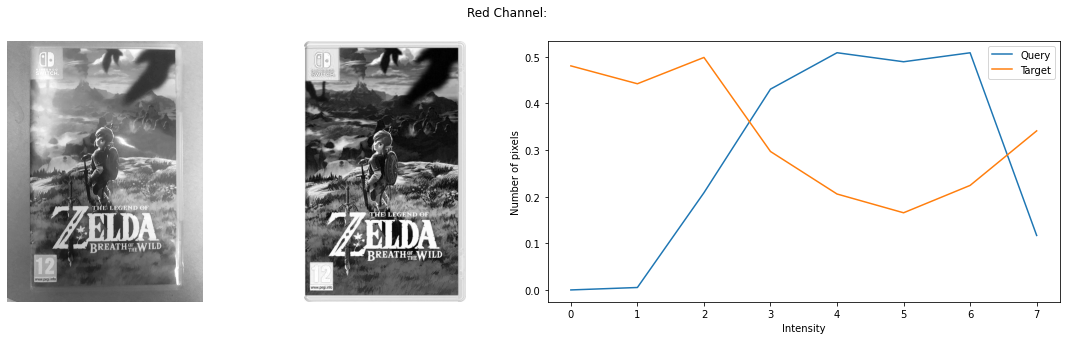

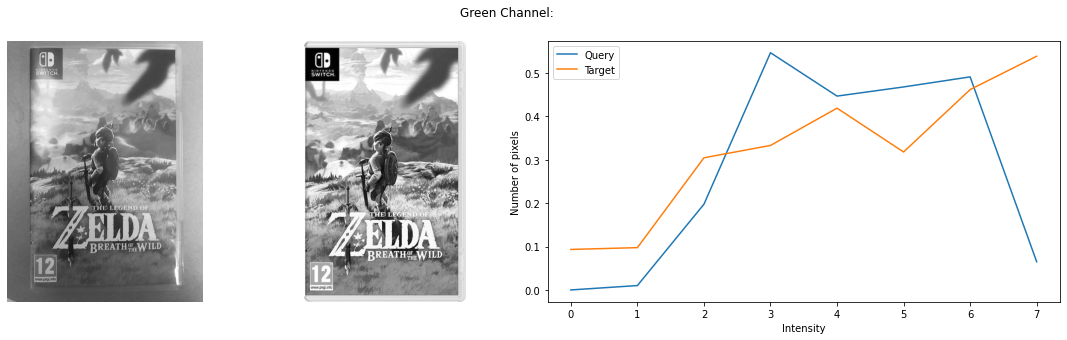

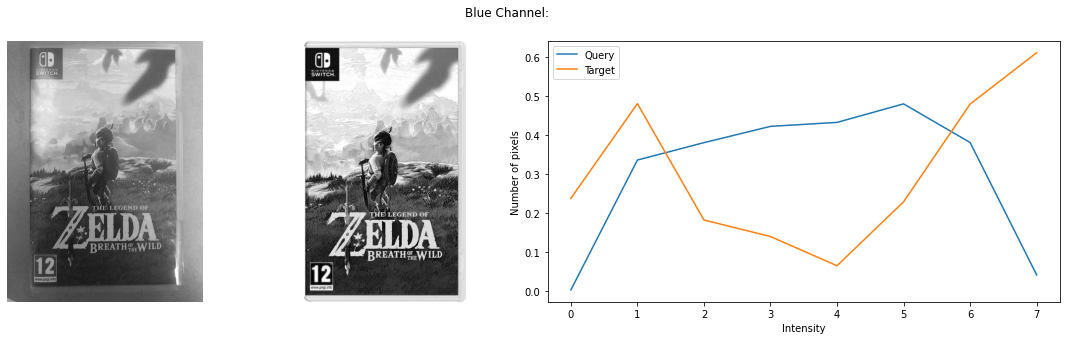

In [19]:
## EXTRACT THE QUERY AND TARGET IMAGES
## FOR THE ZELDA BOX ART, WHICH HAD
## A STRONG NEGATIVE CORRELATION
Q_IMAGE = QUERY_IMAGES.iloc[7]['image']
T_IMAGE = TARGET_IMAGES.iloc[7]['image']

## SEPERATE THE CHANNELS INTO
## MULTIPLE BLACK/WHITE IMAGES
q_red, q_green, q_blue = cv2.split(Q_IMAGE)
t_red, t_green, t_blue = cv2.split(T_IMAGE)

## PLOT EACH CHANNEL TO SEE THE DIFFERENCES
## BETWEEN THE HISTOGRAMS MORE CLEARLY
plot_color_channel('Red Channel:', q_red, t_red)
plot_color_channel('Green Channel:', q_green, t_green)
plot_color_channel('Blue Channel:', q_blue, t_blue)

* `Red Channel`: We can see the 'glare' of the reflected light quite clearly causing the deep black values to disappear and therefore increase the total amount 'redness' in the image not present on the actual box art, which causes the negative correlation in the red channel.
* `Green Channel`: Seems to be mostly correct but can't quite reach the bright green values that are present in the target image on areas like the grass patches and bloomy sky, but nothing noteworthy.
* `Blue Channel`: This one is all over the place. The grass is not as dark, but the sky is not as bright. This is once again likely due to the loss of color information from the warm light emitted from my desk lamp.

It seems that the conditions that need to be met for a good correlation between the images is too strict for the environment we are aiming for. If the images need to be taken with near perfect lightning conditions it's not flexible enough to be used as a solution for the problem we are trying to solve.

## 📝 7. Conclusion
Unless lightning conditions are optimal, I can't really recommend using this approach to filter on the number of images that feature description matching needs to be performed on. Too much color information of the box-art is lost when capturing the image in 'average' lightning conditions.

We've attempted several comparison techniques but none of them brought decent enough results to be of use.
* `cv2.HISTCMP_CORREL`: High preference to red/white images due to sensitivity with light, not recommended.
* `cv2.HISTCMP_CHISQR`: Somewhat varied results but doesn't bring up the target on the top results consistently.
* `cv2.HISTCMP_INTERSECT`: Performs worse than the correlation. Don't use for this use case.
* `cv2.HISTCMP_BHATTACHARYYA`: Similar to the correlation but with smaller differences between the distances.

After we've concluded that none of these comparison techniques resulted in anything useful we've investigated an image with exceptional poor results and taken a deeper look at what exactly was going on. We could clearly see that the light reflected from the light source (a warm colored lamp) influenced the red channel too much causing the blue channel to lose a lot of valuable information. Oddly enough the green channel remained mostly unaffected by this.